# Testing the stats of sample likelihood values

In [1]:
import numpy as np
import observables
import ppwd
import TOFPlanet
import generic_priors
import losses
import ahelpers as ah
import samplooker as spl

import matplotlib.pyplot as plt
plt.style.use('ndefault')
%matplotlib inline

In [2]:
from scipy.stats import norm, chi2, multivariate_normal
import emcee

## This is output from a uranus seeding (J0) run including prior-ed rotation period

In [3]:
C,L = ah.load_chain('uranusJ0chain.npz')
burn = 2000
skip = 400
C = C[:,burn::skip,:]
L = L[:,burn::skip]

In [4]:
X = np.empty((0,12))
lvals = np.empty(0)
for k in range(C.shape[0]):
    X = np.vstack((X, C[k,:,:]))
    lvals = np.append(lvals, L[k,:])

privals = np.empty_like(lvals)
for k in range(X.shape[0]):
    privals[k] = ppwd.ppwd_prior(X[k,1:], observables.Uranus())

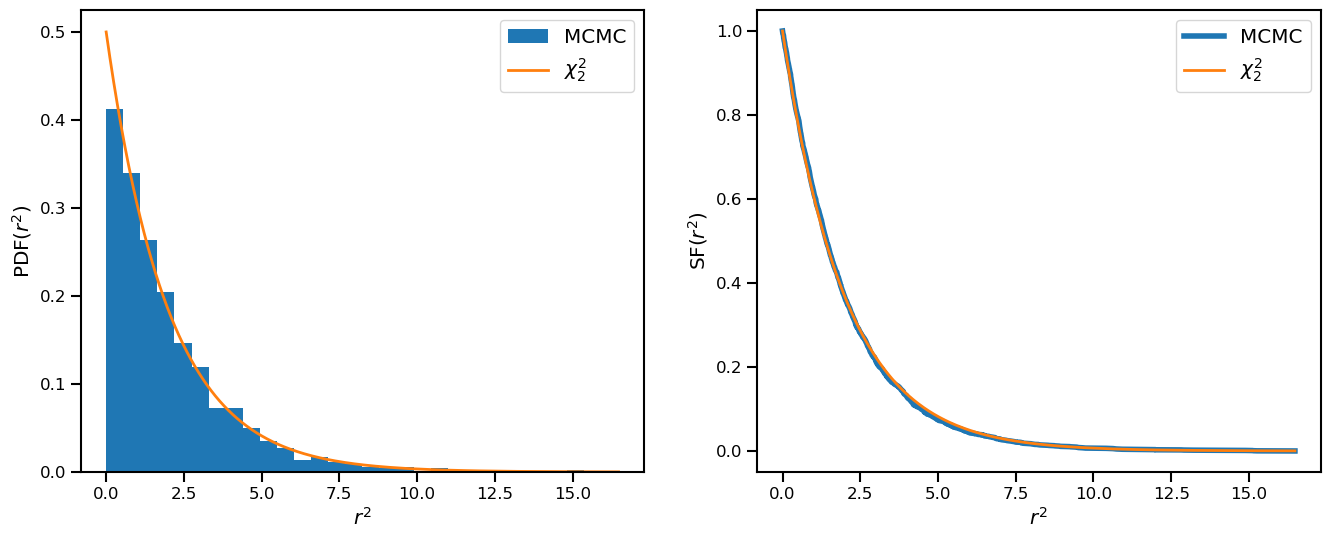

In [5]:
rvals_c = np.sqrt(-2*(lvals - privals))
N = rvals_c.size
ecdf = np.arange(1,N+1)/N

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(rvals_c**2, density=True, label='MCMC');
plt.plot(np.sort(rvals_c**2), chi2.pdf(np.sort(rvals_c**2),2), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('PDF$(r^2)$');
plt.legend();

plt.subplot(1,2,2)
plt.plot(np.sort(rvals_c**2), 1 - ecdf, label='MCMC', linewidth=4);
plt.plot(np.sort(rvals_c**2), chi2.sf(np.sort(rvals_c**2),2), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('SF$(r^2)$');
plt.legend();

### Let's look at cooked planets from this sample

In [6]:
planets = ah.load_planets('uranusJ0sample_b2k_s400_planets.pickle')
obs = observables.Uranus()

Found 3200 planets in uranusJ0sample_b2k_s400_planets.pickle.


The two terms in the likelihood are rotation period and 1-bar density. Actually I consider rotation period part of the prior, because it can be evaluated independently of the converged model, but it's not part of the `ppwd.ppwd_prior` so I count it in the likelihood's degrees of freedom. In addition, there is a pesky max-density prior that only sometimes remains from the `generic_priors.gas_planet` call but it's probably not a problem. I will remove it at some point soon.

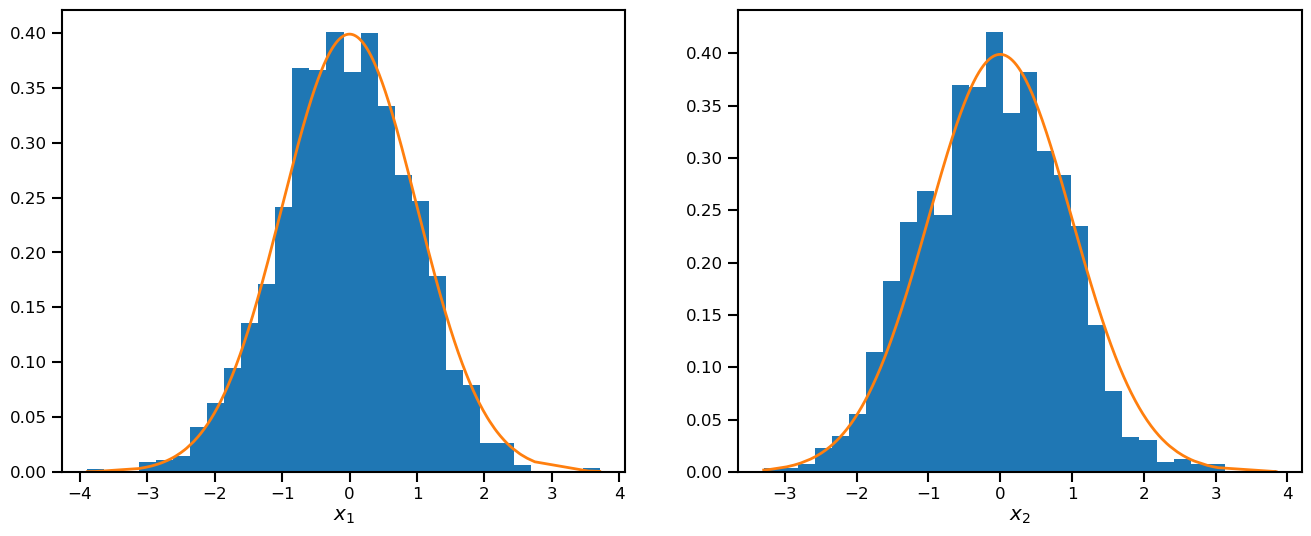

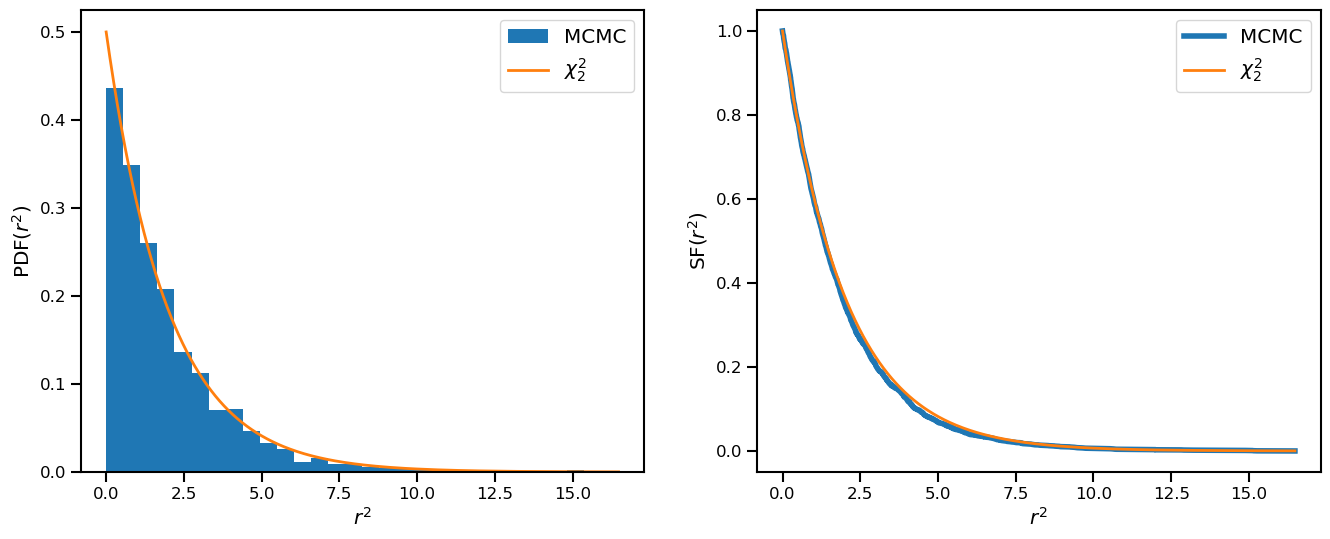

In [7]:
rho0 = np.array([p.rhoi[0] for p in planets])
P = np.array([p.period for p in planets])
x1 = (rho0 - obs.rho0)/obs.drho0
x2 = (P - obs.P)/(obs.dP/2) # obs.dP is 2-sigma

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(x1, density=True, label='MCMC')
plt.plot(np.sort(x1), norm.pdf(np.sort(x1)))
plt.xlabel('$x_1$')

plt.subplot(1,2,2)
plt.hist(x2, density=True, label='MCMC')
plt.plot(np.sort(x2), norm.pdf(np.sort(x2)))
plt.xlabel('$x_2$');

rvals_p = np.sqrt(x1**2 + x2**2)
N = rvals_p.size
ecdf = np.arange(1,N+1)/N

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(rvals_p**2, density=True, label='MCMC');
plt.plot(np.sort(rvals_p**2), chi2.pdf(np.sort(rvals_p**2),2), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('PDF$(r^2)$');
plt.legend();

plt.subplot(1,2,2)
plt.plot(np.sort(rvals_p**2), 1 - ecdf, label='MCMC', linewidth=4);
plt.plot(np.sort(rvals_p**2), chi2.sf(np.sort(rvals_p**2),2), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('SF$(r^2)$');
plt.legend();

## But a quenching run with J2 and J4 added to the likelihood is more difficult

In [8]:
planets = ah.load_planets('uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_obs0_PV_planets.pickle')

Found 1000 planets in uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_obs0_PV_planets.pickle.


In addition to the rotation period and 1-bar density this sample was taken with a likelihood function that included two more terms, _independently_ measuring the $J_2$ and $J_4$ distance from their observed values. So we would expect each term to be normally distributed and their sum-of-squares to follow $\chi^2$ with 4 dof. But it's not so simple:

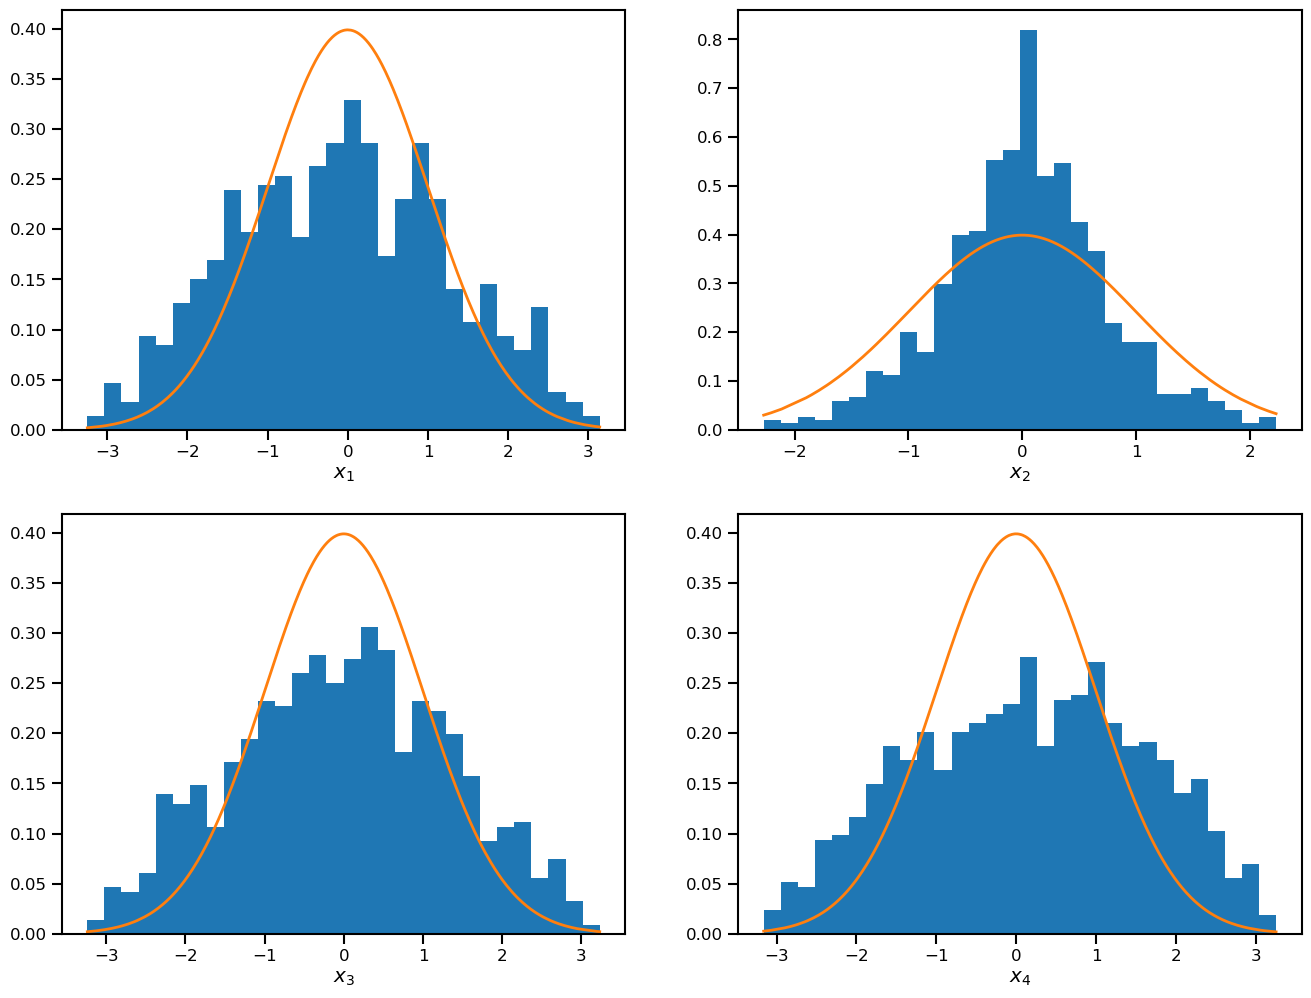

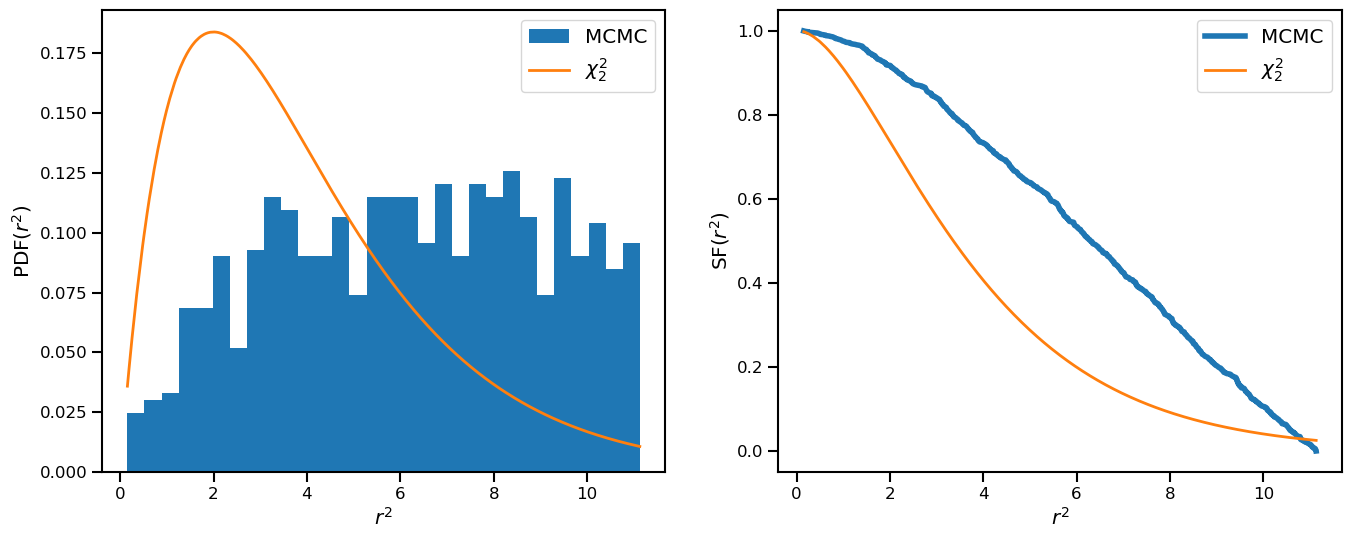

In [9]:
rho0 = np.array([p.rhoi[0] for p in planets])
P = np.array([p.period for p in planets])
J2 = np.array([p.Js[1] for p in planets]) # Js [J0,J2,J4,...]
J4 = np.array([p.Js[2] for p in planets])
x1 = (rho0 - obs.rho0)/obs.drho0
x2 = (P - obs.P)/(obs.dP/2) # obs.dP is 2-sigma
x3 = (J2 - obs.J2)/obs.dJ2
x4 = (J4 - obs.J4)/obs.dJ4

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.hist(x1, density=True, label='MCMC')
plt.plot(np.sort(x1), norm.pdf(np.sort(x1)))
plt.xlabel('$x_1$')

plt.subplot(2,2,2)
plt.hist(x2, density=True, label='MCMC')
plt.plot(np.sort(x2), norm.pdf(np.sort(x2)))
plt.xlabel('$x_2$');

plt.subplot(2,2,3)
plt.hist(x3, density=True, label='MCMC')
plt.plot(np.sort(x3), norm.pdf(np.sort(x3)))
plt.xlabel('$x_3$');

plt.subplot(2,2,4)
plt.hist(x4, density=True, label='MCMC')
plt.plot(np.sort(x4), norm.pdf(np.sort(x4)))
plt.xlabel('$x_4$');

rvals_p = np.sqrt(x1**2 + x2**2 + x3**2 + x4**2)
N = rvals_p.size
ecdf = np.arange(1,N+1)/N

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(rvals_p**2, density=True, label='MCMC');
plt.plot(np.sort(rvals_p**2), chi2.pdf(np.sort(rvals_p**2),4), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('PDF$(r^2)$');
plt.legend();

plt.subplot(1,2,2)
plt.plot(np.sort(rvals_p**2), 1 - ecdf, label='MCMC', linewidth=4);
plt.plot(np.sort(rvals_p**2), chi2.sf(np.sort(rvals_p**2),4), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('SF$(r^2)$');
plt.legend();

The problem is that MCMC never works as easily as the examples in the tutorials make it look, and we have a very difficult sampling space to explore. Not only are the 11 free parameters that define $\rho(s)$ highly correlated with respect to how they combine to create a density profile, when the likelihood function includes the gravity Js it becomes highly sensitive to small changes in the density. In other words, start with a vector $\mathbf{x}$ in the sample space that defines a planet with an excellent match to $J_2$ and $J_4$. Now make a small random variation in one of the numbers $x(i)$ while keeping the others fixed. The resulting $\rho(s)$ will almost certainly be a _terrible_ match with the Js.

To get the ensemble sampler to explore the sample space we have to emply a "tempering" loop, where we start a chain exploring an artificially inflated ("high temperature") likelihood function, then bring down the temperature in steps until we run a chain of some length with the actual likelihood. Some of the final links in that final chain correspond to high likelihood states in parameter space; we save those and restart the process again from fresh seeds. Eventually we collect enough of the high likelihood states, hopefully spread all over the sample space. I cannot prove, and it probably is not true, that this loop counts as a formal MCMC algorithm. So I don't assign any meaning to the relative frequencies within the sample. But hopefully we can make some inferences based on the sample _spread_ of quantities of interest, like MoI etc.

In the above sample, "high likelihood" was defined as states with $r \lesssim 3.57$ which is the 2.5 "sigma equivalent" with 4 degrees of freedom:

In [10]:
def sig2r(sig, p):
    """The sigma equivalent in p degrees of freedom"""
    return np.sqrt(chi2.ppf(norm.cdf(sig) - norm.cdf(-sig), p))
print(sig2r(2.5, 4))

3.5744689744679468


The sample values of r obey the cutoff, even though they are overly weighted towards the higher $r$ values:

In [11]:
print(rvals_p.max())

3.3360786456610922


But there is a problem. Even though the combined $r$ value is always less than the set threshold, an individual dimension in any $\mathbf{x}$ can have deviations somewhat larger than its own 2.5 sigma, if the other dimensions in that particular vector have smaller deviations. Looking at the histrograms above it becomes clear why many models can have $J_2$ or $J_4$ deviatons above 3 sigma: the other dimensions for the same model have smaller deviations.

We can detect the "offending" planets.

In [12]:
ind = (x3 > 2.5) | (x4 > 2.5)
i = np.nonzero(ind)[0][0]
print(x1[i], x2[i], x3[i], x4[i])
print(rvals_p[i])

-1.381089356337857 0.04185182017916911 2.949144350365101 0.3339383261767777
3.273855004428597


I removed those high deviation models and generated more models with a stricter definition of the threshold to bring us back to 1000 planets. Here is what the stricter sample looks like.

In [13]:
planets = ah.load_planets('uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_obs0S_PV_planets.pickle')

Found 1000 planets in uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_obs0S_PV_planets.pickle.


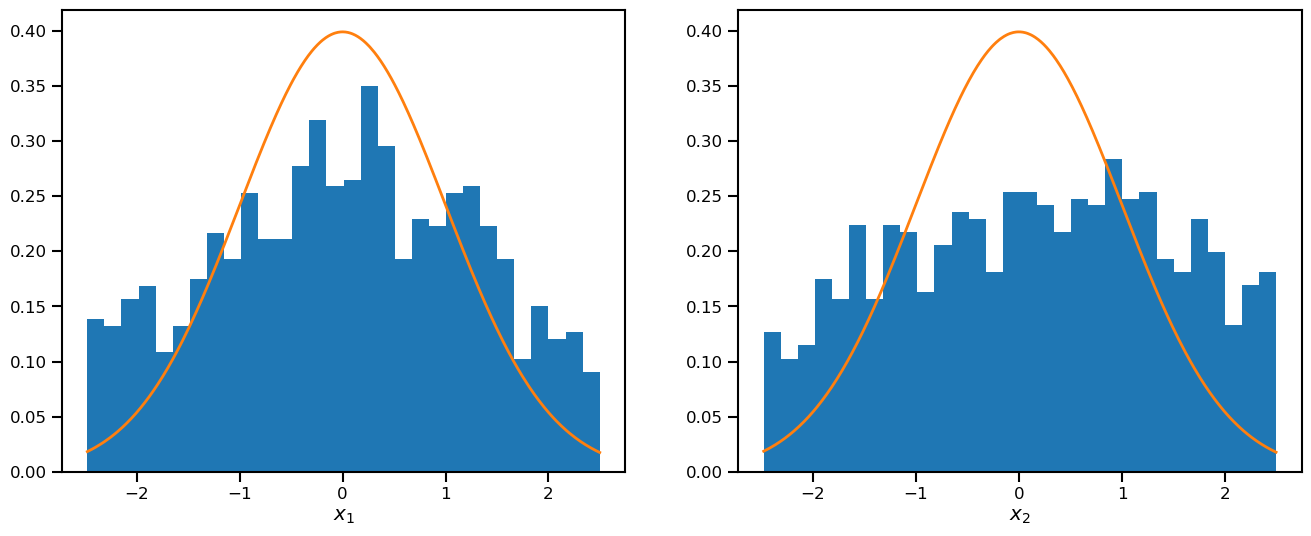

In [14]:
J2 = np.array([p.Js[1] for p in planets])
J4 = np.array([p.Js[2] for p in planets])
x1 = (J2 - obs.J2)/obs.dJ2
x2 = (J4 - obs.J4)/obs.dJ4

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(x1, density=True, label='MCMC')
plt.plot(np.sort(x1), norm.pdf(np.sort(x1)))
plt.xlabel('$x_1$')

plt.subplot(1,2,2)
plt.hist(x2, density=True, label='MCMC')
plt.plot(np.sort(x2), norm.pdf(np.sort(x2)))
plt.xlabel('$x_2$');

## In the correlated Js sample this is what the deviations look like in the sample

In [15]:
planets = ah.load_planets('uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_FR0p5J6_PV_planets.pickle')

Found 1000 planets in uranus/perpres_fixref_uncon_ppwd/deg6_tof4_J4_FR0p5J6_PV_planets.pickle.


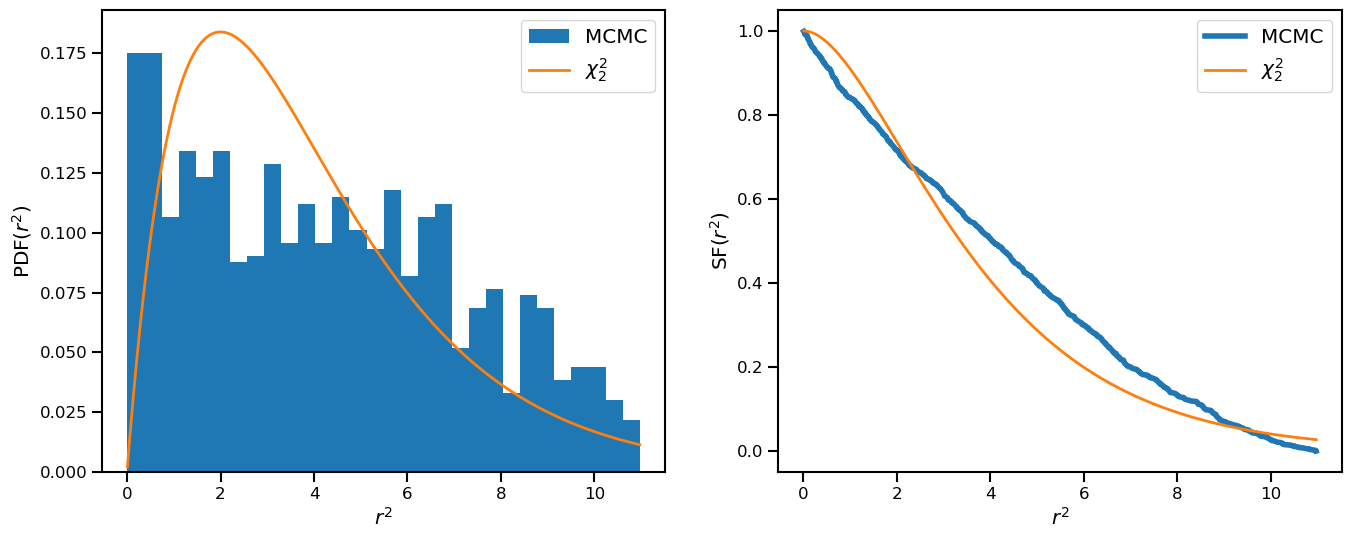

In [16]:
rvals_p = np.array([losses._french23(p,obs) for p in planets])
N = rvals_p.size
ecdf = np.arange(1,N+1)/N

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(rvals_p**2, density=True, label='MCMC');
plt.plot(np.sort(rvals_p**2), chi2.pdf(np.sort(rvals_p**2),4), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('PDF$(r^2)$');
plt.legend();

plt.subplot(1,2,2)
plt.plot(np.sort(rvals_p**2), 1 - ecdf, label='MCMC', linewidth=4);
plt.plot(np.sort(rvals_p**2), chi2.sf(np.sort(rvals_p**2),4), label=r'$\chi^2_2$');
plt.xlabel('$r^2$');
plt.ylabel('SF$(r^2)$');
plt.legend();

The tempering loop oversamples planets in the lower likelihood region. I don't think we can avoid that. But we can adjust our threshold detection to avoid the lowest likelihood models.

In [17]:
rvals_p.max()

3.312029853527263

The largest deviation is consistent with the threshold we asked for, which is reasonable for the 4 degrees of freedom in the full likelihood, but is too large when we focus on just the Js.